# Retrieving, Calculating, and Visualizing Perturbed Wind ICON Forecast Data

This notebook demonstrates the full workflow for accessing, calculating, and visualizing perturbed wind forecast data from the ICON numerical weather model. The data is provided by MeteoSwiss as part of Switzerland’s Open Government Data (OGD) initiative.

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed in-house to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as deaccumulation and regridding.

For visualization, this notebook uses the [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html) library developed by ECMWF, which offers intuitive plotting tools for meteorological data.

---

## 🔍 **What You’ll Do in This Notebook**

 🛰️  **Retrieve**  
    Fetch deterministic ICON forecast data (e.g., 10m grid eastward and 10m grid northward wind data from ICON) via the `ogd_api` module.

 📐  **Calculate**  
    Calculate wind speed with [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `speed` function.

 🧭  **Regrid**  
    Interpolate ICON data from its native, icosahedral grid to a regular latitude/longitude grid.

 🌍  **Visualize**  
    Plot the processed data on a map with meteorological styling using [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html).

---

## Retrieving Precipitation Forecast
In this first part, we retrieve wind forecast data from the ICON numerical weather model. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2-resized.PNG](./images/browser-ch2-resized.PNG)

### Creating Requests
To retrieve the forecast data, we first define a set of API requests using the `ogd_api.Request` class.
Each request targets a different lead time, which is the elapsed time since the forecast's start time (reference or initialization datetime).
In this example, we retrieve eastward wind 10 meters above the surface (`U_10M`) and northward wind 10 meters above the surface (`V_10M`) at the initialization time of the forecast.

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [41]:
from datetime import datetime, timezone
from meteodatalab import ogd_api

# Set default date of today midnight in UTC
today_midnight_utc = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

req_U10 = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="U_10M",
    reference_datetime=today_midnight_utc,
    perturbed=True,
    horizon="P0DT0H",
)

req_V10 = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="V_10M",
    reference_datetime=today_midnight_utc,
    perturbed=True,
    horizon="P0DT0H",
)

Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch2`). |
| `variable`           | Meteorological variable of interest (`TOT_PREC` = total precipitation). |
| `reference_datetime` | Initialization time of the forecast in **UTC**, provided as either:<br>- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) object (e.g.,<br> &nbsp; `datetime.datetime(2025, 5, 22, 9, 0, 0, tzinfo=datetime.timezone.utc)`) <br>- [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations) date string (e.g., `"2025-05-22T09:00:00Z"`)|
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `horizon`            | Forecast lead time, provided as either:<br>– [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) object (e.g., `datetime.timedelta(hours=2)`) <br>– [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Durations) duration string (e.g., `"P0DT2H"`)|

### Retrieving Data
We now send our list of requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing "HTTPError: 403 Client Error: Forbidden for url", you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [42]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_U = ogd_api.get_from_ogd(req_U10)
da_V = ogd_api.get_from_ogd(req_V10)

## Data Preprocessing

Once the data has been loaded, continue with the preprocessing of the data if needed. The following preprocessing steps
are described here:
- Calculating the wind speed
- Regridding the data to a regular latitude/longitude grid

### Calculating Wind Speed


In [43]:
from meteodatalab.operators import wind

wind_speed = wind.speed(da_U, da_V)

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 1 member (for deterministic data)
- `ref_time`: Single reference time (e.g. default date of today midnight)
- `lead_time`: 3 hourly intervals
- `cell`: 283,876 spatial grid points

It includes attributes specifying some meta data such as:

- `parameter`: information on the meteorogical parameter, here total precipitation
- `vcoord_type`: information of the vertical coordinate type, here surface field

> &#x1F525; **Expert users:** If you are interested in detailed meta data information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

### Regridding to a Regular Grid
To enable visualization or comparison with other geospatial datasets, you may want to regrid the ICON data from its native, unstructured grid onto a regular latitude/longitude grid. This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

Below, we define the target grid using a bounding box over the area of interest, specify the output resolution, and apply the remapping.


In [88]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Define the target grid extent and resolution
xmin, xmax = -0.817, 18.183   # Longitude bounds
ymin, ymax = 41.183, 51.183   # Latitude bounds
nx, ny = 950, 500             # Number of grid points in x and y

# Create a regular lat/lon grid using EPSG:4326
destination = regrid.RegularGrid(
    CRS.from_string("epsg:4326"), nx, ny, xmin, xmax, ymin, ymax
)

# Remap ICON native grid data to the regular grid
wind_geo_list = []
num_of_eps = len(wind_speed.eps)

for i in range(num_of_eps):
    wind_geo = regrid.iconremap(wind_speed.isel(eps=i), destination)
    wind_geo_list.append(wind_geo)

## Visualizing Wind Speed
We now visualize the predicted wind speeds on a map. This uses [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), the visualization component of [Earthkit](https://earthkit.readthedocs.io/en/latest/) — a suite of tools designed to simplify access, processing, and visualization of weather and climate data in Python.

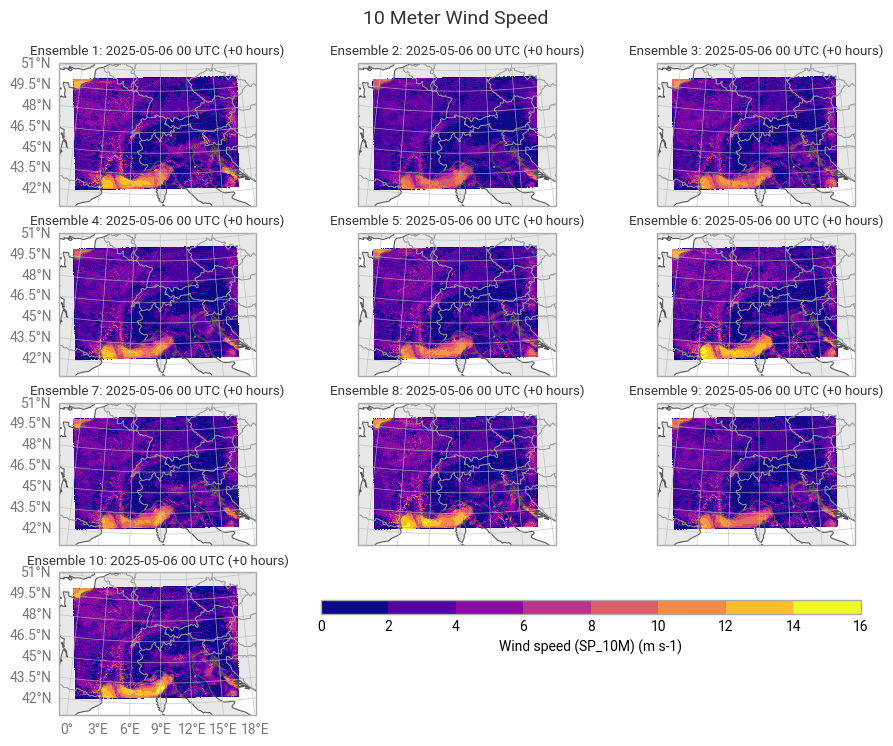

In [ ]:
from earthkit.plots.geo import domains
import earthkit
import pandas as pd
import matplotlib.pyplot as plt

# Define the map domain using the regridded data's bounding box
domain = domains.Domain.from_bbox(
    bbox=[xmin, xmax, ymin, ymax],
    name="CH2"
)

# Create the figure instance including subplots
figure = earthkit.plots.Figure(domain=domain, size=(9, 7), rows=4, columns=3)

for i in range(num_of_eps):

    # Plot the rigridded precipitation field for each subplot
    wind_geo = wind_geo_list[i]
    subplot = figure.add_map(i//3, i%3)
    subplot.grid_cells(wind_geo, x="lon", y="lat")

    # Extract forecast metadata
    ref_time = pd.to_datetime(wind_geo.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H UTC")
    lead_time = wind_geo.coords["lead_time"].values[0].astype('timedelta64[h]')
    eps = wind_geo.coords["eps"].values

    # Prepare title for each subplot
    parameter = wind_geo.attrs["parameter"]
    title = f"Ensemble {eps}: {ref_time} (+{lead_time})"

    # Add subplot title
    subplot.title(title)

# Add standard  features
figure.land()
figure.coastlines()
figure.borders()
figure.gridlines()

# Prepare legend
wind_param = wind_geo_list[0].attrs["parameter"]
legend_label = f"{wind_param['name']} ({wind_param['units']})"
ax = plt.axes((0.35, 0.17, 0.6, 0.02))

# Add figure title and legend
figure.title("10 Meter Wind Speed")
figure.legend(label=legend_label, ax=ax)

# Display the figure
figure.show()